In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

dataset_path = os.path.realpath(os.getcwd() + "\\dataset")

Text(0, 0.5, 'Price Value')

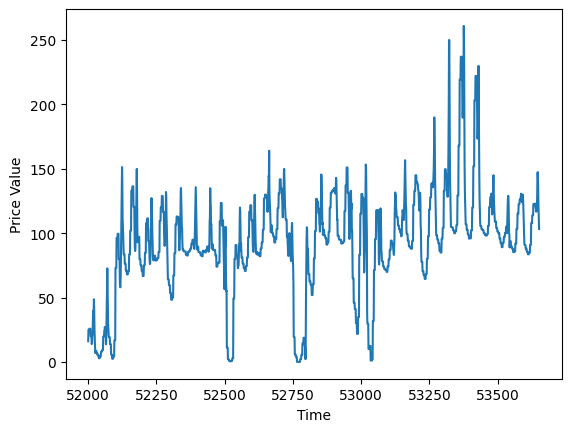

In [2]:
ppr_data = pd.read_csv(dataset_path + '\\power_prices_realized.csv')
ppr_data['delivery_time_utc'] = pd.to_datetime(ppr_data['delivery_time_utc'])
ppr_data.sort_values(by='delivery_time_utc', inplace = True)

#Depuis le début de la guerre d'Ukraine
ppr_data = ppr_data[52000:]

plt.plot(ppr_data.index, ppr_data["da_price"], label = 'da_price')
plt.xlabel("Time")
plt.ylabel("Price Value")

Baseline

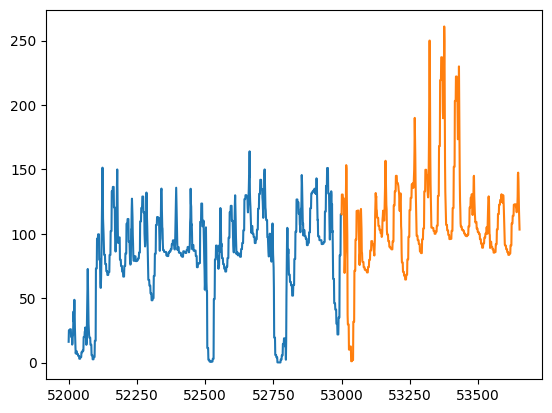

In [3]:
time = ppr_data.index
series = ppr_data['da_price'].to_numpy()

# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

plt.plot(time_train, x_train)
plt.plot(time_valid, x_valid)

# Regression

In [4]:
# Parameters
window_size = 100
batch_size = 128
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [6]:
# Build the model
model_baseline = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(2, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()

# Set the training parameters
model_baseline.compile(loss="mse", optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9))

# Train the model
model_baseline.fit(dataset,epochs=100)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 202       
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
 dense_2 (Dense)             (None, 1)                 3         
                                                                 
Total params: 211 (844.00 Byte)
Trainable params: 211 (844.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100

8/8 [==============================] - 1s 10ms/step - loss: 6171.7607
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 2658.0916
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 1579.8058
Epoch 4/100
8/8 [===================

In [7]:
#PREDICTION

def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model_baseline, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

6/6 [==============================] - 0s 35ms/step


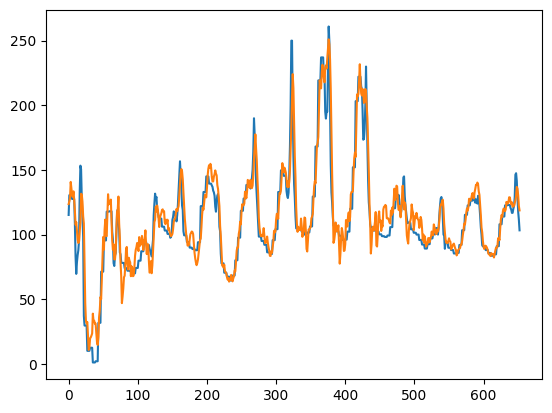

In [8]:
plt.plot(x_valid)
plt.plot(results)

In [9]:
## Compute the MAE and MSE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

177.17972
9.249942
